In [323]:
import pandas as pd
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix,accuracy_score

In [324]:
### Utility Functions
from IPython.display import display, HTML
import pandas as pd
import sqlite3
from sqlite3 import Error

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows


In [325]:
with open('taxi_fare_data.csv', 'r') as f:
        results = []
        for line in f:
            
            words = line.strip('\n').split(',')
            
            results.append(words)

In [326]:
# key - Unique string identifying each row in both the training and test sets. Comprised of pickup_datetime plus a unique integer, but this doesn't matter, it should just be used as a unique ID field. Required in your submission CSV. Not necessarily needed in the training set, but could be useful to simulate a 'submission file' while doing cross-validation within the training set.
# Features
# pickup_datetime - timestamp value indicating when the taxi ride started.
# pickup_longitude - float for longitude coordinate of where the taxi ride started.
# pickup_latitude - float for latitude coordinate of where the taxi ride started.
# dropoff_longitude - float for longitude coordinate of where the taxi ride ended.
# dropoff_latitude - float for latitude coordinate of where the taxi ride ended.
# passenger_count - integer

In [327]:

def step1_create_taxi_table(database_filename):
    # Inputs: Name of the data and normalized database filename
    # Output: None

    create_table_taxi = """CREATE TABLE IF NOT EXISTS [TaxiData] (
        [trip_id] integer not null Primary Key autoincrement,
        [timestamp] Text  ,
        [fare_amount] float,
        [pickup_datetime] Text ,
        [pickup_longitude] float,
        [pickup_latitude] float ,
        [dropoff_longitude] float ,
        [dropoff_latitude] float ,
        [passenger_count] Integer 
        
        );
        """
    conn = create_connection(database_filename)
    create_table(conn, create_table_taxi,drop_table_name='TaxiData')


    with conn:        
            cursor = conn.cursor() 
            cursor.executemany("""INSERT INTO TaxiData('timestamp',
             'fare_amount',
             'pickup_datetime',
             'pickup_longitude',
             'pickup_latitude',
             'dropoff_longitude',
             'dropoff_latitude',
             'passenger_count')
            VALUES (?,?,?,?,?,?,?,?)""",results[1:])

    conn.commit()

In [328]:
database_filename = 'finalproject.db'
step1_create_taxi_table(database_filename)
conn = create_connection(database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM TaxiData""", conn)


In [329]:
df.head()

,trip_id,timestamp,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,1,2015-06-30 23:59:54.000000300,8.0,2015-06-30 23:59:54 UTC,-73.968117,40.751141,-73.980461,40.732216,1
1,2,2015-06-30 23:59:52.000000100,9.5,2015-06-30 23:59:52 UTC,-73.944077,40.711658,-73.982857,40.719799,1
2,3,2015-06-30 23:59:48.000000300,33.5,2015-06-30 23:59:48 UTC,-73.970360,40.783756,-73.870560,40.709118,1
3,4,2015-06-30 23:59:48.000000200,6.0,2015-06-30 23:59:48 UTC,-73.978867,40.750820,-73.989326,40.740780,2
4,5,2015-06-30 23:59:46.000000100,24.5,2015-06-30 23:59:46 UTC,-73.987198,40.739059,-73.962769,40.672539,2


In [330]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   trip_id            200000 non-null  int64  
 1   timestamp          200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  200000 non-null  float64
 7   dropoff_latitude   200000 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [331]:
#checking null values
df.isnull().sum()



trip_id              0
timestamp            0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [332]:
# check duplicate values
df.duplicated().sum()



0

In [333]:
df.describe()

,trip_id,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,100000.500000,13.468479,-72.895664,40.156331,-72.950900,40.189314,1.689470
std,57735.171256,12.262425,8.873970,4.886445,8.652198,4.832543,1.336832
min,1.000000,-100.000000,-171.797348,0.000000,-171.797348,0.000000,0.000000
25%,50000.750000,6.500000,-73.992012,40.735687,-73.991348,40.734523,1.000000
50%,100000.500000,9.500000,-73.981812,40.752670,-73.979897,40.753468,1.000000
75%,150000.250000,15.000000,-73.967062,40.767239,-73.962784,40.768250,2.000000
max,200000.000000,900.000000,0.000000,69.702576,0.000000,405.049988,9.000000


In [334]:
#Outlier removal

# fare_amount: 1 to 500
# longitudes: -75 to -72
# latitudes: 40 to 43
# passenger_count: 1 to 6



def remove_outliers(df):
    return df[(df['fare_amount'] >= 1.) & 
              (df['fare_amount'] <= 500.) &
              (df['pickup_longitude'] >= -75) & 
              (df['pickup_longitude'] <= -72) & 
              (df['dropoff_longitude'] >= -75) & 
              (df['dropoff_longitude'] <= -72) & 
              (df['pickup_latitude'] >= 40) & 
              (df['pickup_latitude'] <= 43) & 
              (df['dropoff_latitude'] >=40) & 
              (df['dropoff_latitude'] <= 43) & 
              (df['passenger_count'] >= 1) & 
              (df['passenger_count'] <= 6)]

In [335]:
df=remove_outliers(df)

In [336]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196611 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   trip_id            196611 non-null  int64  
 1   timestamp          196611 non-null  object 
 2   fare_amount        196611 non-null  float64
 3   pickup_datetime    196611 non-null  object 
 4   pickup_longitude   196611 non-null  float64
 5   pickup_latitude    196611 non-null  float64
 6   dropoff_longitude  196611 non-null  float64
 7   dropoff_latitude   196611 non-null  float64
 8   passenger_count    196611 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 15.0+ MB


In [337]:
# calculate distances in miles
import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km/0.621


In [338]:
def add_trip_distance(df):
    df['trip_distance'] = haversine_np(df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude'])

In [339]:
add_trip_distance(df)

In [340]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196611 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   trip_id            196611 non-null  int64  
 1   timestamp          196611 non-null  object 
 2   fare_amount        196611 non-null  float64
 3   pickup_datetime    196611 non-null  object 
 4   pickup_longitude   196611 non-null  float64
 5   pickup_latitude    196611 non-null  float64
 6   dropoff_longitude  196611 non-null  float64
 7   dropoff_latitude   196611 non-null  float64
 8   passenger_count    196611 non-null  int64  
 9   trip_distance      196611 non-null  float64
dtypes: float64(6), int64(2), object(2)
memory usage: 16.5+ MB


In [341]:
df['timestamp']=pd.to_datetime(df['timestamp'])

In [342]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196611 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   trip_id            196611 non-null  int64         
 1   timestamp          196611 non-null  datetime64[ns]
 2   fare_amount        196611 non-null  float64       
 3   pickup_datetime    196611 non-null  object        
 4   pickup_longitude   196611 non-null  float64       
 5   pickup_latitude    196611 non-null  float64       
 6   dropoff_longitude  196611 non-null  float64       
 7   dropoff_latitude   196611 non-null  float64       
 8   passenger_count    196611 non-null  int64         
 9   trip_distance      196611 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(2), object(1)
memory usage: 16.5+ MB


In [343]:



# pickup_datetime feature

def extract_time_features(df):
    timezone_name = 'America/New_York'
    time_column = "pickup_datetime"
    df.index = pd.to_datetime(df[time_column])
    df.index = df.index.tz_convert(timezone_name)
    df["dow"] = df.index.weekday
    df["hour"] = df.index.hour
    df["month"] = df.index.month
    df["year"] = df.index.year
    return df.reset_index(drop=True)


In [344]:
df = extract_time_features(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196611 entries, 0 to 196610
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   trip_id            196611 non-null  int64         
 1   timestamp          196611 non-null  datetime64[ns]
 2   fare_amount        196611 non-null  float64       
 3   pickup_datetime    196611 non-null  object        
 4   pickup_longitude   196611 non-null  float64       
 5   pickup_latitude    196611 non-null  float64       
 6   dropoff_longitude  196611 non-null  float64       
 7   dropoff_latitude   196611 non-null  float64       
 8   passenger_count    196611 non-null  int64         
 9   trip_distance      196611 non-null  float64       
 10  dow                196611 non-null  int64         
 11  hour               196611 non-null  int64         
 12  month              196611 non-null  int64         
 13  year               196611 non-null  int64   

In [345]:
df.isnull().sum()

trip_id              0
timestamp            0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
trip_distance        0
dow                  0
hour                 0
month                0
year                 0
dtype: int64

In [346]:
df.duplicated().sum()

0

In [347]:
df.describe()

,trip_id,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,dow,hour,month,year
count,196611.000000,196611.000000,196611.000000,196611.000000,196611.000000,196611.000000,196611.000000,196611.000000,196611.000000,196611.000000,196611.0,196611.0
mean,99970.874107,13.447374,-73.973692,40.750317,-73.973604,40.751230,1.692133,5.672918,2.834572,12.143278,6.0,2015.0
std,57762.677192,11.868408,0.039233,0.028030,0.036865,0.032025,1.339673,6.384694,2.140182,5.872546,0.0,0.0
min,1.000000,1.000000,-74.780418,40.498440,-74.780418,40.350159,1.000000,0.000000,0.000000,0.000000,6.0,2015.0
25%,49926.500000,6.500000,-73.992172,40.737011,-73.991463,40.735764,1.000000,2.049102,1.000000,7.000000,6.0,2015.0
50%,99940.000000,9.500000,-73.982048,40.753231,-73.980232,40.753963,1.000000,3.503817,3.000000,13.000000,6.0,2015.0
75%,150019.500000,15.000000,-73.968033,40.767538,-73.963936,40.768440,2.000000,6.506431,5.000000,17.000000,6.0,2015.0
max,200000.000000,475.000000,-73.135628,41.095119,-73.135628,41.236969,6.000000,129.747472,6.000000,23.000000,6.0,2015.0


In [348]:
df[df['fare_amount']<0]

,trip_id,timestamp,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,dow,hour,month,year


In [349]:
df[df['fare_amount']>500]

,trip_id,timestamp,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,dow,hour,month,year


In [350]:
df[df['pickup_longitude']==0]

,trip_id,timestamp,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,dow,hour,month,year


In [351]:
df[df['trip_distance']==0]

,trip_id,timestamp,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,dow,hour,month,year
199,205,2015-06-30 23:45:56.000000500,2.50,2015-06-30 23:45:56 UTC,-73.972702,40.761154,-73.972702,40.761154,1,0.0,1,19,6,2015
328,338,2015-06-30 23:36:31.000000200,26.80,2015-06-30 23:36:31 UTC,-73.953705,40.734467,-73.953705,40.734467,1,0.0,1,19,6,2015
346,356,2015-06-30 23:35:04.000000400,30.00,2015-06-30 23:35:04 UTC,-73.972435,40.758846,-73.972435,40.758846,1,0.0,1,19,6,2015
1340,1362,2015-06-30 22:37:35.000000100,70.00,2015-06-30 22:37:35 UTC,-74.072502,40.795361,-74.072502,40.795361,1,0.0,1,18,6,2015
1695,1721,2015-06-30 22:18:34.000000400,2.50,2015-06-30 22:18:34 UTC,-74.002182,40.755627,-74.002182,40.755627,1,0.0,1,18,6,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195325,198696,2015-06-20 21:50:55.000000400,2.50,2015-06-20 21:50:55 UTC,-74.000404,40.738010,-74.000404,40.738010,1,0.0,5,17,6,2015
196082,199465,2015-06-20 21:07:20.000000200,9.50,2015-06-20 21:07:20 UTC,-73.985420,40.768196,-73.985420,40.768196,1,0.0,5,17,6,2015
196188,199574,2015-06-20 21:00:44.000000600,8.00,2015-06-20 21:00:44 UTC,-73.976242,40.751377,-73.976242,40.751377,1,0.0,5,17,6,2015
196248,199634,2015-06-20 20:56:46.000000200,57.54,2015-06-20 20:56:46 UTC,-73.945915,40.775475,-73.945915,40.775475,2,0.0,5,16,6,2015


In [352]:
df[df['passenger_count']>6]

,trip_id,timestamp,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,dow,hour,month,year


In [353]:
df.pickup_datetime.min(), df.pickup_datetime.max()

('2015-06-20 20:33:55 UTC', '2015-06-30 23:59:54 UTC')

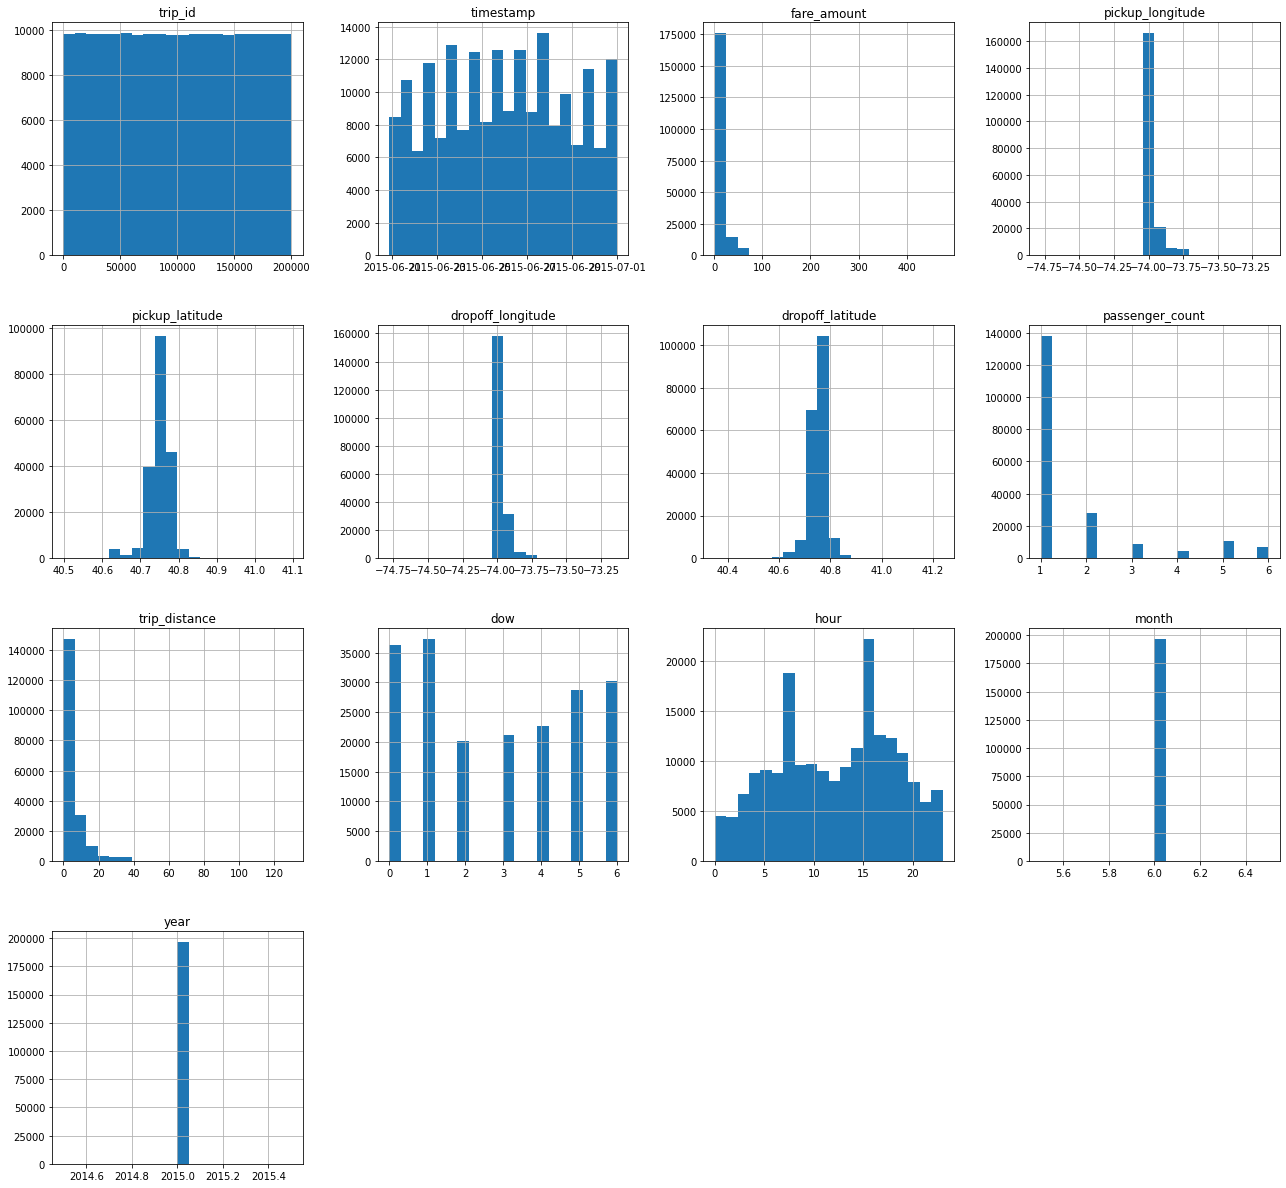

In [354]:
df.hist(figsize=(22,21), bins=20);


In [355]:
input_cols = ['passenger_count',
       'trip_distance', 'dow', 'hour', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude','dropoff_longitude'
       ]
target_col = 'fare_amount'

In [356]:
cols=['passenger_count','trip_distance', 'dow', 'hour','fare_amount','pickup_latitude', 'pickup_longitude','dropoff_latitude','dropoff_longitude']
data=df[cols]

In [357]:
one_hot_encoded_data= pd.get_dummies(data, columns= ['dow'])

In [358]:
one_hot_encoded_data.head()

,passenger_count,trip_distance,hour,fare_amount,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,1,3.777487,19,8.0,40.751141,-73.968117,40.732216,-73.980461,0,1,0,0,0,0,0
1,1,5.457855,19,9.5,40.711658,-73.944077,40.719799,-73.982857,0,1,0,0,0,0,0
2,1,19.011739,19,33.5,40.783756,-73.970360,40.709118,-73.870560,0,1,0,0,0,0,0
3,2,2.288864,19,6.0,40.750820,-73.978867,40.740780,-73.989326,0,1,0,0,0,0,0
4,2,12.356255,19,24.5,40.739059,-73.987198,40.672539,-73.962769,0,1,0,0,0,0,0


In [359]:
def myfunc(x):
    if x>12 and x<=16 :
        return 'Noon'
    elif x>=8 and x<=12:
        return 'Morning'
    elif  x>16 and x<=20:
        return 'Evening'
    else:
        return 'Night'

one_hot_encoded_data['hour_bin'] = one_hot_encoded_data.apply(lambda x: myfunc(x.hour), axis=1)

In [360]:
one_hot_encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196611 entries, 0 to 196610
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   passenger_count    196611 non-null  int64  
 1   trip_distance      196611 non-null  float64
 2   hour               196611 non-null  int64  
 3   fare_amount        196611 non-null  float64
 4   pickup_latitude    196611 non-null  float64
 5   pickup_longitude   196611 non-null  float64
 6   dropoff_latitude   196611 non-null  float64
 7   dropoff_longitude  196611 non-null  float64
 8   dow_0              196611 non-null  uint8  
 9   dow_1              196611 non-null  uint8  
 10  dow_2              196611 non-null  uint8  
 11  dow_3              196611 non-null  uint8  
 12  dow_4              196611 non-null  uint8  
 13  dow_5              196611 non-null  uint8  
 14  dow_6              196611 non-null  uint8  
 15  hour_bin           196611 non-null  object 
dtypes:

In [361]:
one_hot_encoded_data= pd.get_dummies(one_hot_encoded_data, columns= ['hour_bin'])

In [362]:
one_hot_encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196611 entries, 0 to 196610
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   passenger_count    196611 non-null  int64  
 1   trip_distance      196611 non-null  float64
 2   hour               196611 non-null  int64  
 3   fare_amount        196611 non-null  float64
 4   pickup_latitude    196611 non-null  float64
 5   pickup_longitude   196611 non-null  float64
 6   dropoff_latitude   196611 non-null  float64
 7   dropoff_longitude  196611 non-null  float64
 8   dow_0              196611 non-null  uint8  
 9   dow_1              196611 non-null  uint8  
 10  dow_2              196611 non-null  uint8  
 11  dow_3              196611 non-null  uint8  
 12  dow_4              196611 non-null  uint8  
 13  dow_5              196611 non-null  uint8  
 14  dow_6              196611 non-null  uint8  
 15  hour_bin_Evening   196611 non-null  uint8  
 16  ho

In [363]:
one_hot_encoded_data=one_hot_encoded_data.drop(columns='hour')

In [364]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_encoded_data, test_size=0.2, random_state=42)
len(train_df), len(val_df)

(157288, 39323)

In [365]:
train_df.columns

Index(['passenger_count', 'trip_distance', 'fare_amount', 'pickup_latitude',
       'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'dow_0',
       'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6',
       'hour_bin_Evening', 'hour_bin_Morning', 'hour_bin_Night',
       'hour_bin_Noon'],
      dtype='object')

In [366]:
inp_col=['passenger_count', 'trip_distance', 'dow_0', 'dow_1',
       'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'hour_bin_Evening',
       'hour_bin_Morning', 'hour_bin_Night', 'hour_bin_Noon']
out_col=['fare_amount']
train_inputs = train_df[inp_col]
train_targets = train_df[out_col]
train_inputs.head(3)

,passenger_count,trip_distance,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,hour_bin_Evening,hour_bin_Morning,hour_bin_Night,hour_bin_Noon
124493,1,1.450610,0,0,1,0,0,0,0,0,0,0,1
193316,4,2.636467,0,0,0,0,0,1,0,1,0,0,0
113558,5,34.252201,0,0,0,1,0,0,0,0,0,1,0


In [367]:
train_targets.head()

,fare_amount
124493,16.00
193316,6.50
113558,57.54
138152,5.50
175955,19.00


In [368]:
#validation
val_inputs = val_df[inp_col]
val_targets = val_df[out_col]

In [369]:
#Modelling

In [370]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

linreg_model = LinearRegression()
linreg_model.fit(train_inputs, train_targets)
train_preds = linreg_model.predict(train_inputs)
val_preds = linreg_model.predict(val_inputs)
train_rmse = mean_squared_error(train_targets, train_preds, squared=False)
val_rmse = mean_squared_error(val_targets, val_preds, squared=False)
print('RMSE Score on Validation data',val_rmse)
print('RMSE Score on Validation data',train_rmse)

RMSE Score on Validation data 5.222886038225811
RMSE Score on Validation data 5.3821574104548615


In [371]:
import numpy
from numpy import arange
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
#from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

In [372]:
# Test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'neg_root_mean_squared_error'

In [373]:
# Spot-Check Algorithms
models = []
models.append(( 'LR' , LinearRegression()))
models.append(( 'LASSO' , Lasso()))
models.append(( 'EN' , ElasticNet()))
models.append(( 'KNN' , KNeighborsRegressor()))
models.append(( 'CART' , DecisionTreeRegressor()))

In [374]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, train_inputs, train_targets, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -5.363259 (0.457169)
LASSO: -5.425973 (0.445931)
EN: -5.427672 (0.445222)
KNN: -5.511066 (0.427254)
CART: -7.228710 (0.468455)


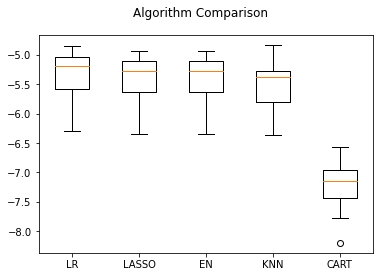

In [375]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle( 'Algorithm Comparison' )
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [376]:
# Standardize the dataset
pipelines = []
pipelines.append(( 'ScaledLR' , Pipeline([( 'Scaler' , StandardScaler()),( 'LR' ,
    LinearRegression())])))
pipelines.append(( 'ScaledLASSO' , Pipeline([( 'Scaler' , StandardScaler()),( 'LASSO' ,
    Lasso())])))

pipelines.append(( 'ScaledEN' , Pipeline([( 'Scaler' , StandardScaler()),( 'EN' ,
    ElasticNet())])))
pipelines.append(( 'ScaledKNN' , Pipeline([( 'Scaler' , StandardScaler()),( 'KNN' ,
    KNeighborsRegressor())])))
pipelines.append(( 'ScaledCART' , Pipeline([( 'Scaler' , StandardScaler()),( 'CART' ,
    DecisionTreeRegressor())])))
#pipelines.append(( 'ScaledSVR' , Pipeline([( Scaler , StandardScaler()),( SVR , SVR())])))
results = []
names = []
for name, model in pipelines:
                          kfold = KFold(n_splits=num_folds)
                          cv_results = cross_val_score(model, train_inputs, train_targets, cv=kfold, scoring=scoring)
                          results.append(cv_results)
                          names.append(name)
                          msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
                          print(msg)

ScaledLR: -5.363342 (0.457150)
ScaledLASSO: -5.516400 (0.429604)
ScaledEN: -6.661515 (0.337587)
ScaledKNN: -5.545968 (0.437003)
ScaledCART: -7.127752 (0.460601)


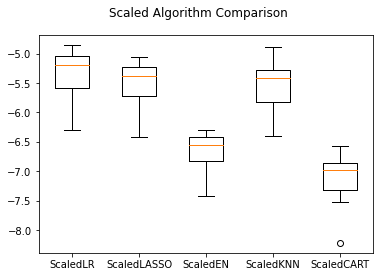

In [377]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle( 'Scaled Algorithm Comparison ')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [383]:
# ensembles
ensembles = []
ensembles.append(( 'ScaledAB' , Pipeline([( 'Scaler' , StandardScaler()),( 'AB' ,
    AdaBoostRegressor())])))
ensembles.append(( 'ScaledGBM' , Pipeline([( 'Scaler' , StandardScaler()),( 'GBM' ,
    GradientBoostingRegressor())])))
ensembles.append(( 'ScaledRF' , Pipeline([( 'Scaler' , StandardScaler()),( 'RF' ,
    RandomForestRegressor())])))
ensembles.append(( 'ScaledET' , Pipeline([( 'Scaler' , StandardScaler()),( 'ET' ,
    ExtraTreesRegressor())])))

results = []
model_list = []
names = []
for name, model in ensembles:
                          kfold = KFold(n_splits=num_folds)
                          cv_results = cross_val_score(model, train_inputs, train_targets, cv=kfold, scoring=scoring)
                          
                          model_list.append(())  
                          results.append(cv_results)
                          names.append(name)
                          msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
                      

/Users/sunybuffalo/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sunybuffalo/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sunybuffalo/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sunybuffalo/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/sunybuffalo/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/sunybuffalo/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/sunybuffalo/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/sunybuffalo/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversion

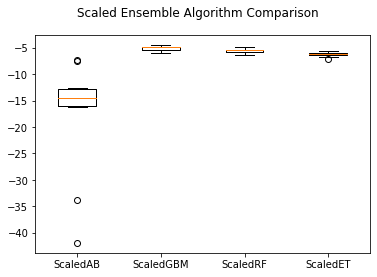

In [384]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle( 'Scaled Ensemble Algorithm Comparison' )
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [386]:
#validation
val_inputs = val_df[inp_col]
val_targets = val_df[out_col]

In [387]:
out_col

['fare_amount']

In [388]:
# prepare the model
scaler = StandardScaler().fit(train_inputs)
rescaledX = scaler.transform(train_inputs)
model = AdaBoostRegressor()
model.fit(rescaledX, train_targets)
rescaledValidationX = scaler.transform(val_inputs)
predictions = model.predict(rescaledValidationX)



/Users/sunybuffalo/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [389]:
# Dataset reformulation for Visualization

val_df.head()
val_df.insert(14, "predicted_fair_amt", predictions, True)


In [391]:
import folium
from branca.element import Figure
fig3=Figure(width=550,height=350)

m3=folium.Map(location=[40.721319, -73.844311],tiles='cartodbpositron',zoom_start=11)
fig3.add_child(m3)

#Adding markers to the map
i = 0
for index, row in val_df.iterrows():

    if i <11:
        x,y = row["pickup_latitude"], row["pickup_longitude"] 
        fare = np.round(row["predicted_fair_amt"],2)
        folium.Marker(location=[x,y],popup='Default popup Marker1',tooltip="$"+str(fare)).add_to(m3)
        i = i+1
m3

In [393]:
import matplotlib.pyplot as plt

# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

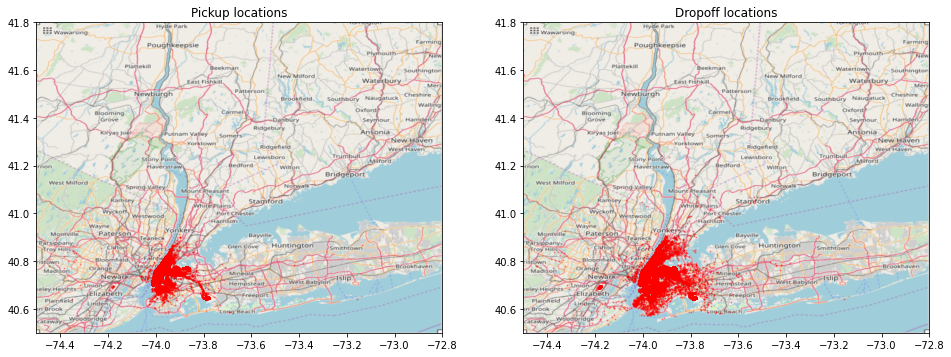

In [394]:
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('nyc.png')
plot_on_map(train_df, BB, nyc_map, s=1, alpha=0.3)